# Stock Market Detection Wyckoff using Machine Learning

## 🧩 Cell 1: Import Libraries

In [ ]:
# 1️⃣ Import Libraries และ Configurations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from cassandra.cluster import Cluster
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import ta # Library สำหรับ Technical Analysis

# กำหนดสไตล์การแสดงผลกราฟ
plt.style.use('dark_background')

# --- Config ---
symbol = "BTC" 
DATA_LIMIT = 300  
TRAIN_SPLIT = 0.8  
# =================
print(f"--- 🧠 Configuration Loaded for {symbol} ---")

## 🧩 Cell 2: ฟังก์ชันดึงข้อมูลจาก Cassandra

In [11]:
# 2️⃣ ฟังก์ชันดึงข้อมูลจาก Cassandra (แก้ไข high_price -> 'high')
def get_candlestick_data(symbol: str, limit: int = 3000):
    """ดึงข้อมูลแท่งเทียนจาก Cassandra และจัดรูปแบบ"""
    try:
        cluster = Cluster(['127.0.0.1'], port=9042)
        session = cluster.connect('stock_data')
    except Exception as e:
        # ใช้ ConnectionRefusedError เพื่อให้ Main Execution จับ Error ได้
        raise ConnectionRefusedError(f"Could not connect to Cassandra: {e}. Check if it's running.")

    query = f"""
        SELECT time, open_price, high_price, low_price, close_price, volume
        FROM candlestick_data
        WHERE symbol='{symbol}'
        ORDER BY time DESC
        LIMIT {limit} 
    """
    rows = session.execute(query)
    df = pd.DataFrame(rows)

    if df.empty:
        raise ValueError(f"No data found for {symbol}")

    df.columns = df.columns.str.lower().str.strip()
    
    # ✅ แก้ไข: high_price ต้องเปลี่ยนเป็น 'high'
    df.rename(columns={'open_price': 'open', 'high_price': 'high', 'low_price': 'low', 'close_price': 'close'}, inplace=True)
    
    df = df.sort_values('time')
    df.set_index('time', inplace=True)
    
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    
    return df

print("✅ Function: get_candlestick_data Loaded.")

✅ Function: get_candlestick_data Loaded.


## 🧩 Cell 3: Feature Engineering (Technical Indicators)

In [12]:
# 3️⃣ Feature Engineering (ML): เพิ่ม Technical Indicators
def add_technical_features(df: pd.DataFrame) -> pd.DataFrame:
    """คำนวณและเพิ่ม Technical Indicators (RSI, MACD, OBV, ATR)"""
    df_copy = df.copy()

    # 1. Relative Strength Index (RSI)
    df_copy['RSI'] = ta.momentum.RSIIndicator(df_copy['close'], window=14).rsi()
    
    # 2. Moving Average Convergence Divergence (MACD)
    macd = ta.trend.MACD(df_copy['close'])
    df_copy['MACD_Line'] = macd.macd()
    df_copy['MACD_Signal'] = macd.macd_signal()
    
    # 3. On-Balance Volume (OBV)
    df_copy['OBV'] = ta.volume.OnBalanceVolumeIndicator(df_copy['close'], df_copy['volume']).on_balance_volume()
    
    # 4. Volatility (ATR)
    df_copy['ATR'] = ta.volatility.AverageTrueRange(df_copy['high'], df_copy['low'], df_copy['close'], window=14).average_true_range()
    
    # 5. Price Change (เป็น Feature สำคัญในการทำนายทิศทาง)
    df_copy['Close_Prev'] = df_copy['close'].shift(1)
    df_copy['Price_Change'] = (df_copy['close'] / df_copy['Close_Prev']) - 1
    
    df_copy = df_copy.dropna()
    
    return df_copy.drop(columns=['Close_Prev'])

print("✅ Function: add_technical_features Loaded.")

✅ Function: add_technical_features Loaded.


## 🧩 Cell 4: เตรียมข้อมูลและฝึกโมเดล Random Forest

In [13]:
# 4️⃣ เตรียมข้อมูลและฝึกโมเดล Random Forest
def prepare_ml_data(data: pd.DataFrame):
    """เตรียมข้อมูลสำหรับการฝึกโมเดล ML (Scaling, Target)"""
    
    # 1. สร้าง Target Label: 1 ถ้า Close Price ของวันถัดไปสูงกว่าวันนี้, 0 ถ้าต่ำกว่าหรือเท่ากับ
    data['target_direction'] = np.where(data['close'].shift(-1) > data['close'], 1, 0)
    data = data.dropna() 

    # 🚨 Features (X): O, H, L, C, V, RSI, MACD_Line, MACD_Signal, OBV, ATR, Price_Change
    feature_columns = ['open', 'high', 'low', 'close', 'volume', 
                       'RSI', 'MACD_Line', 'MACD_Signal', 'OBV', 'ATR', 'Price_Change']
                       
    X = data[feature_columns].values
    y = data['target_direction'].values
    dates = data.index

    # 2. Scaling Features 
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
        
    return X_scaled, y, scaler, dates

def build_and_train_rf(X_train, y_train):
    """สร้างและฝึกโมเดล Random Forest Classifier"""
    
    model = RandomForestClassifier(n_estimators=100, 
                                   max_depth=10, 
                                   random_state=42, 
                                   class_weight='balanced')
    
    print("--- Training Random Forest Model ---")
    model.fit(X_train, y_train)
    print("--- Training Complete ---")
    
    return model

print("✅ Functions: prepare_ml_data, build_and_train_rf Loaded.")

✅ Functions: prepare_ml_data, build_and_train_rf Loaded.


## 🧩 Cell 5: ฟังก์ชัน Plotting

In [ ]:
def plot_ml_forecast(dates, actual_prices, predicted_direction, symbol='SYMBOL', forecast_days=10):
    """วาดกราฟราคาจริงและทิศทางที่คาดการณ์จากโมเดล ML"""
    start_idx = max(0, len(dates) - 100)
    plot_dates_index = dates[start_idx:]
    plot_dates = pd.Series(plot_dates_index) 
    plot_prices = actual_prices[start_idx:]
    plot_direction = predicted_direction[len(predicted_direction) - len(plot_dates):] 
    fig, ax = plt.subplots(figsize=(15, 8))
    
    ax.plot(plot_dates, plot_prices, label='Actual Close Price', color='dodgerblue', linewidth=2)
    
    forecast_start_date = plot_dates.iloc[-forecast_days]
    ax.axvline(forecast_start_date, color='yellow', linestyle='-', linewidth=2, label='Forecast Start Date', zorder=5)

    for i in range(len(plot_dates) - forecast_days, len(plot_dates) - 1):
        current_date = plot_dates.iloc[i] 
        next_date = plot_dates.iloc[i+1]
        current_price = plot_prices[i] 
        next_price = plot_prices[i+1] 
        direction = plot_direction[i]
        
        line_color = 'red' if direction == 0 else 'lime' 

        ax.plot([current_date, next_date], [current_price, next_price], 
                color=line_color, linestyle='--', linewidth=3, alpha=0.7, zorder=4)
                
        mid_date = current_date + (next_date - current_date) / 2 
        mid_price = (current_price + next_price) / 2
        ax.annotate('Up' if direction == 1 else 'Down', 
                    (mid_date, mid_price * 1.001), 
                    color='white', fontsize=8, ha='center', va='bottom', 
                    bbox=dict(facecolor=line_color, alpha=0.8, boxstyle="round,pad=0.3"))

    ax.set_title(f"{symbol} - Random Forest Direction Forecast ({forecast_days} Days Ahead)", color='white', fontsize=16, pad=20)
    ax.set_xlabel("Date", color='white', fontsize=12)
    ax.set_ylabel("Price", color='white', fontsize=12)
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.grid(True, color='gray', linestyle='--', alpha=0.4)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45, ha='right')
    
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), facecolor='black', edgecolor='white', loc='upper left')

    plt.tight_layout()
    plt.show()

print("✅ Function: plot_ml_forecast Loaded.")

✅ Function: plot_ml_forecast Loaded.


## 🧩 Cell 6: Data Preparation (ดึง, สร้าง Feature, แบ่ง Train/Test)

In [ ]:
try:
    print(f"1. ดึงข้อมูล {symbol} (Limit: {DATA_LIMIT} วัน)...")
    df = get_candlestick_data(symbol, limit=DATA_LIMIT)
    
    print("\n2. สร้าง Technical Features (RSI, MACD, OBV, ATR)...")
    df = add_technical_features(df)
    
    print("\n3. เตรียมข้อมูล ML...")
    X, y, scaler, dates = prepare_ml_data(df.copy())
    
    # แบ่งข้อมูล Train/Test
    train_size = int(len(X) * TRAIN_SPLIT)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    print(f"   Shape X_train: {X_train.shape}, Shape X_test: {X_test.shape}")
    print("✅ Data Preparation Complete.")

except ConnectionRefusedError:
    print(f"\n❌ การเชื่อมต่อล้มเหลว: โปรดตรวจสอบว่า Cassandra Server (127.0.0.1:9042) ได้รันอยู่หรือไม่")
except ValueError as e:
    print(f"\n❌ ข้อผิดพลาดข้อมูล: {e}")
except Exception as e:
    print(f"\n❌ เกิดข้อผิดพลาดที่ไม่คาดคิด: {e}")
    print(f"Detail: {type(e).__name__}: {e}")

1. ดึงข้อมูล BTC (Limit: 300 วัน)...

2. สร้าง Technical Features (RSI, MACD, OBV, ATR)...

3. เตรียมข้อมูล ML...
   Shape X_train: (213, 11), Shape X_test: (54, 11)
✅ Data Preparation Complete.


## 🧩 Cell 7: ฝึกโมเดล, ประเมิน และ Plot ผล

--- Training Random Forest Model ---
--- Training Complete ---

5. ประเมินและทำนายทิศทาง...
   Accuracy (Test Set): 0.4630

--- Classification Report (Test Set) ---
               precision    recall  f1-score   support

Down/Same (0)       0.73      0.41      0.52        39
       Up (1)       0.28      0.60      0.38        15

     accuracy                           0.46        54
    macro avg       0.50      0.51      0.45        54
 weighted avg       0.60      0.46      0.49        54


6. แสดงกราฟ Random Forest Direction Forecast...


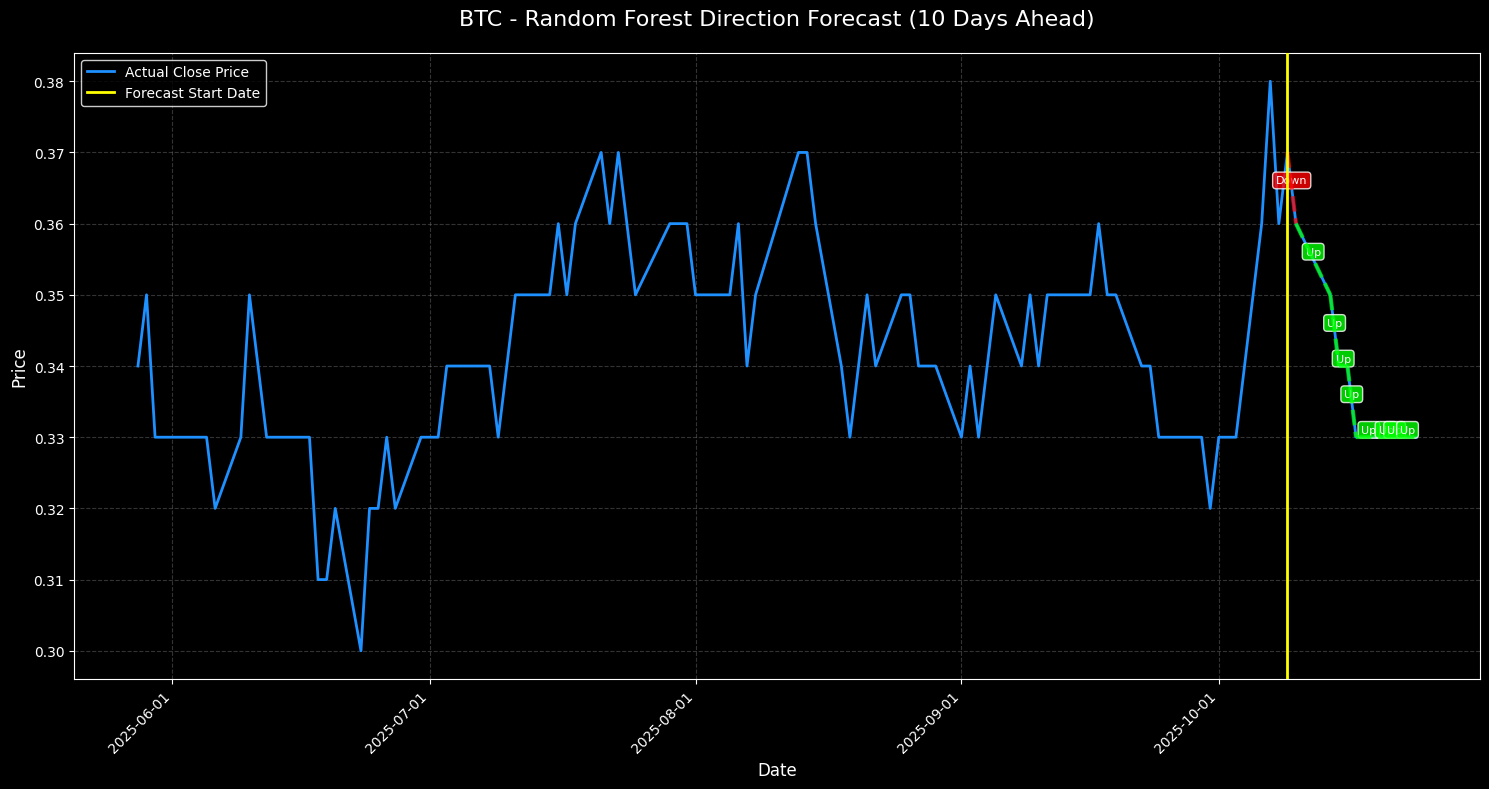

In [16]:
try:
    if 'X_train' in locals() and X_train.size > 0:
        # 4. สร้างและฝึกโมเดล Random Forest
        model = build_and_train_rf(X_train, y_train)
        
        # 5. ทดสอบและคาดการณ์
        print("\n5. ประเมินและทำนายทิศทาง...")
        
        # ประเมิน
        y_pred_test = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred_test)
        print(f"   Accuracy (Test Set): {accuracy:.4f}")
        print("\n--- Classification Report (Test Set) ---")
        print(classification_report(y_test, y_pred_test, target_names=['Down/Same (0)', 'Up (1)']))

        # ทำนายทั้งหมดเพื่อ Plot
        y_pred_all = model.predict(X)
        
        # 6. แสดงผลกราฟ
        print("\n6. แสดงกราฟ Random Forest Direction Forecast...")
        actual_prices = df['close'][dates].values 
        plot_ml_forecast(dates, actual_prices, y_pred_all, symbol=symbol, forecast_days=10)
        
    else:
        print("❌ ไม่สามารถรันได้: ข้อมูล X_train ว่างเปล่าหรือไม่ได้ถูกโหลดใน Cell 6")

except Exception as e:
    print(f"\n❌ เกิดข้อผิดพลาดในขั้นตอนฝึก/ประเมินโมเดล: {e}")
    print(f"Detail: {type(e).__name__}: {e}")